In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.corpus import stopwords
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

Loading the Datasets

In [2]:
df_true = pd.read_csv("C:\\Users\\prask\\OneDrive\\Desktop\\CODING\\Fake News Detection\\True.csv")
df_fake = pd.read_csv("C:\\Users\\prask\\OneDrive\\Desktop\\CODING\\Fake News Detection\\Fake.csv")

Set up of a target and merging both the datasets

In [3]:
df_true['target'] = 1
df_fake['target'] = 0
df = pd.concat([df_true, df_fake]).reset_index(drop = True)
df['original'] = df['title'] + ' ' + df['text']
df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  target  \
0  December 31, 2017        1   
1  December 29, 2017        1   
2  December 31, 2017        1   
3  December 30, 2017        1   
4  December 29, 2017        1   

                                            original  
0  As U.S. budget fight looms, Republicans flip t...  
1  U.S. military to accept transgender recruits o...  
2  Senior U.S. Republican senator: 'Let Mr. Muell...  
3  FBI Russia probe helped by Australian diplomat...  
4  Trump wants Postal Service to charge 'much mor...

Seeing number of null values

In [4]:
df.isnull().sum()

title       0
text        0
subject     0
date        0
target      0
original    0
dtype: int64

Some data cleaning 

In [5]:
nltk.download('stopwords')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2 and token not in stop_words:
            result.append(token)
            
    return result

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prask\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df.subject=df.subject.replace({'politics':'PoliticsNews','politicsNews':'PoliticsNews'})

Exploratory Data analysis 
PART I - Only taking the title into consideration

1. What is the distribution of subjects between true and fake news?

In [7]:
sub_tf_df=df.groupby('target').apply(lambda x:x['title'].count()).reset_index(name='Counts')
sub_tf_df.target.replace({0:'False',1:'True'},inplace=True)
fig = px.bar(sub_tf_df, x="target", y="Counts",
             color='Counts', barmode='group',
             height=400)
fig.show()

2. What issues have been most covered in news?

In [8]:
sub_check=df.groupby('subject').apply(lambda x:x['title'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='subject',y='Counts',color='Counts',title='Count of News Articles by Subject')
fig.show()

3. Word Clouds

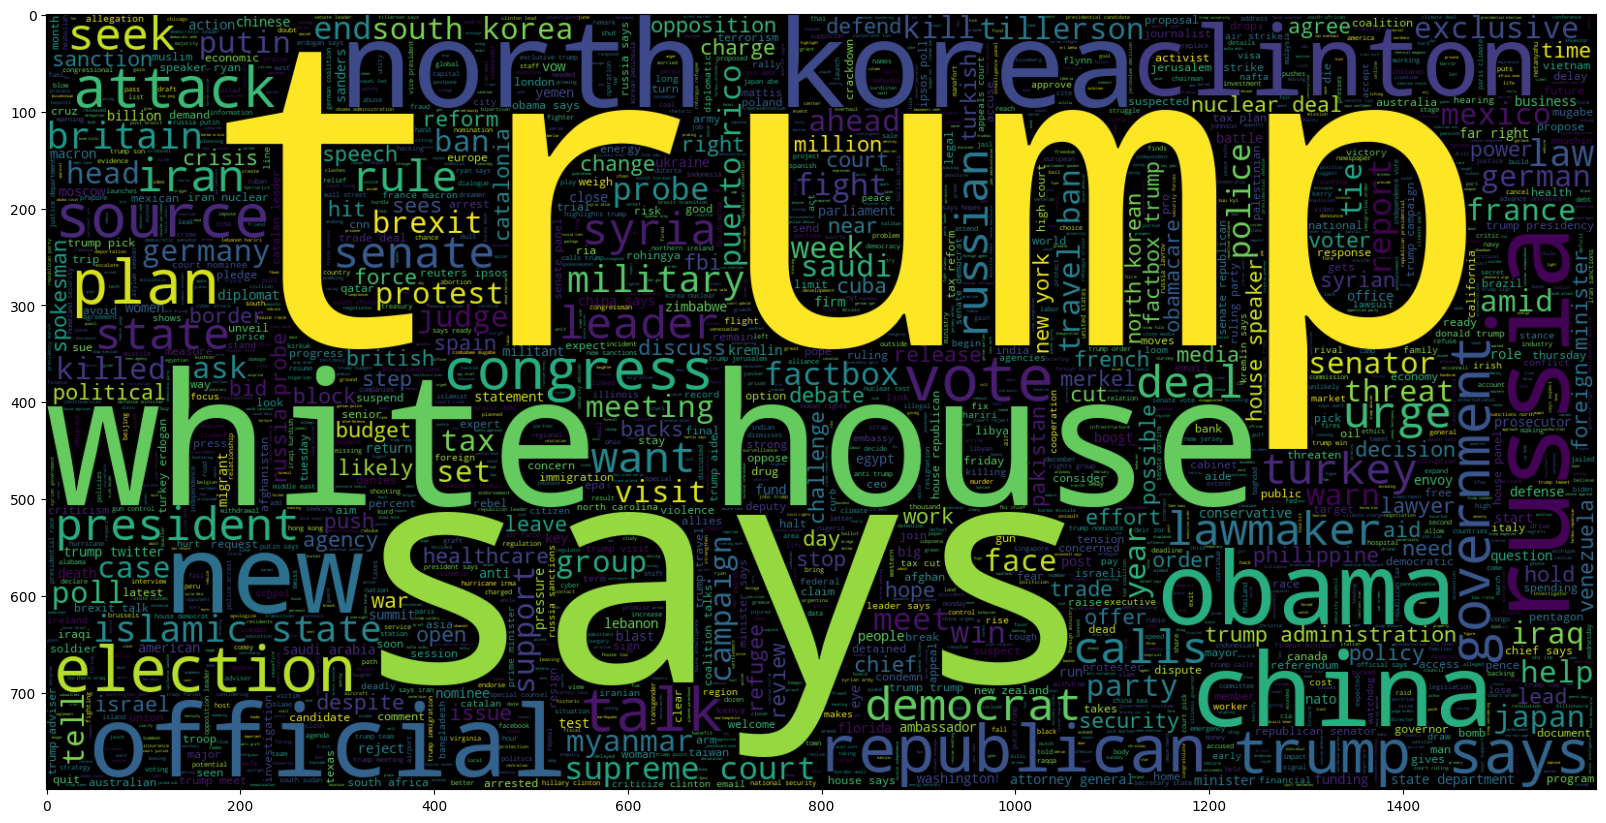

In [9]:
df['clean_title'] = df['title'].apply(preprocess)
df['clean_title'][0]
df['clean_joined_title']=df['clean_title'].apply(lambda x:" ".join(x))
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_title))
plt.imshow(wc, interpolation = 'bilinear')

4. Max count of words in a title

In [10]:
nltk.download('punkt')
maxlen = -1
for doc in df.clean_joined_title:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a title is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_title], nbins = 50)
fig.show()
#From here we come to know that it would be difficult predicting whether or not a news is authentic in 7-8 words

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prask\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


The maximum number of words in a title is = 34


5. Predicting if news is fake or not using only the title

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_title, df.target, test_size=0.25, random_state=42)

# Initialize and fit the CountVectorizer on the training data
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

# Initialize and train the Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2)
model.fit(X_vec_train, y_train)

# Predict on the test set
predicted_value = model.predict(X_vec_test)

# Calculate the ROC AUC score
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)


0.8324194700941243


<AxesSubplot: >

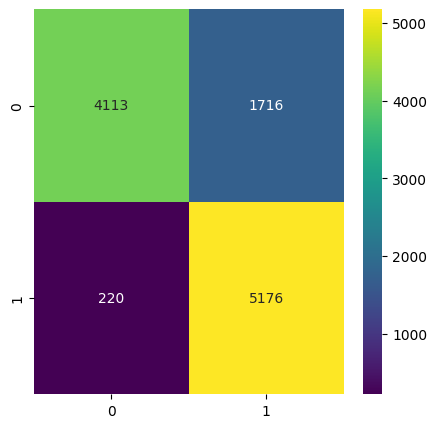

In [12]:
cm = confusion_matrix(list(y_test), predicted_value)
plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True,fmt='g',cmap='viridis')

PART II - Taking the text into consideration

In [13]:
df['clean_text'] = df['text'].apply(preprocess)
df['clean_joined_text']=df['clean_text'].apply(lambda x:" ".join(x))

- Word Clouds

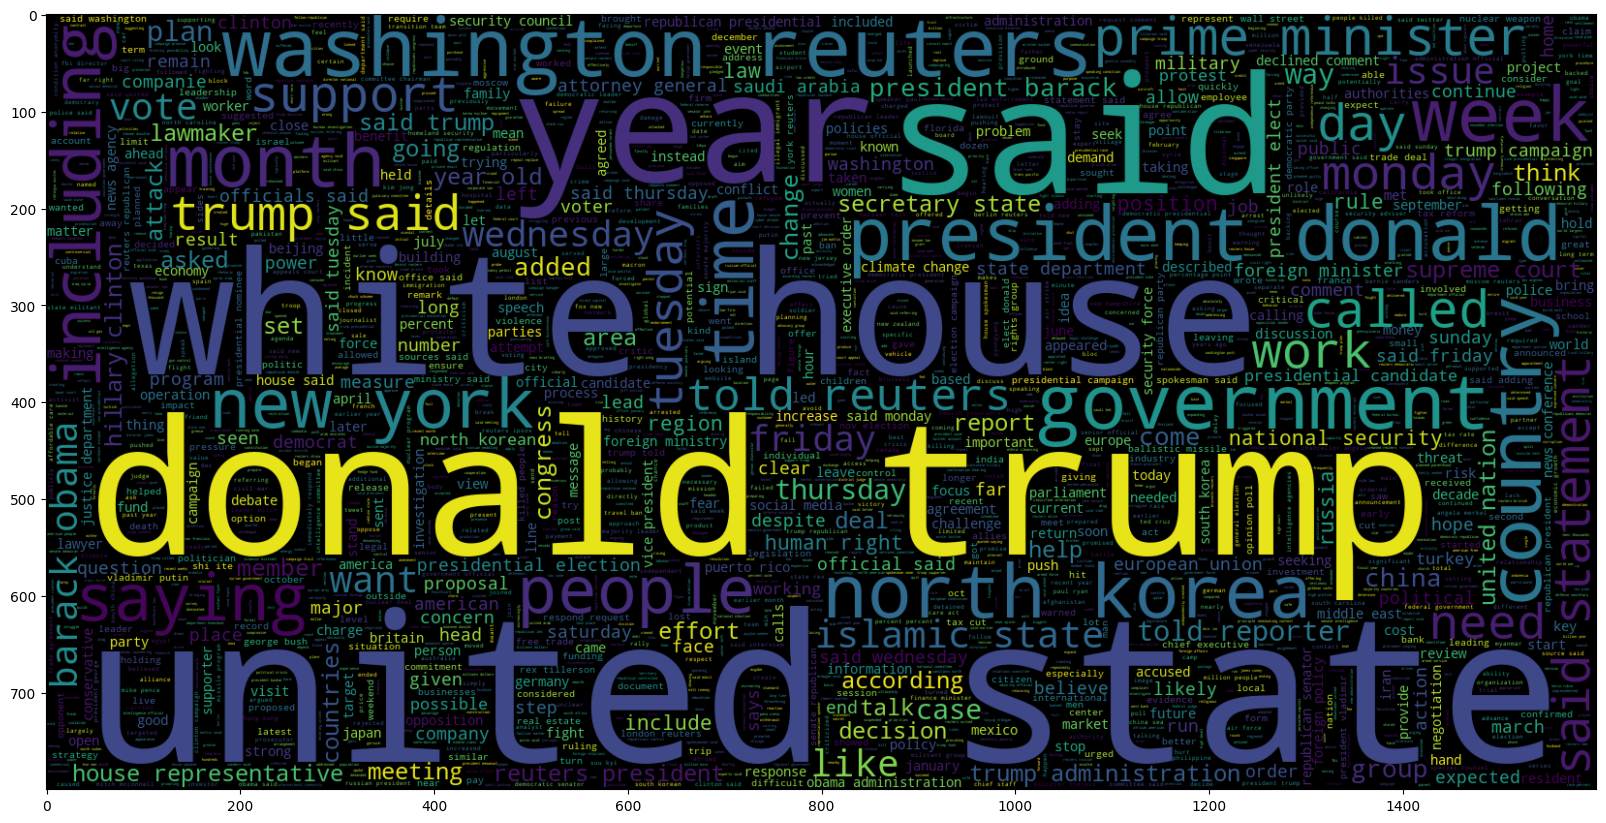

In [14]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 1].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

Word Cloud of news only in the True Dataset

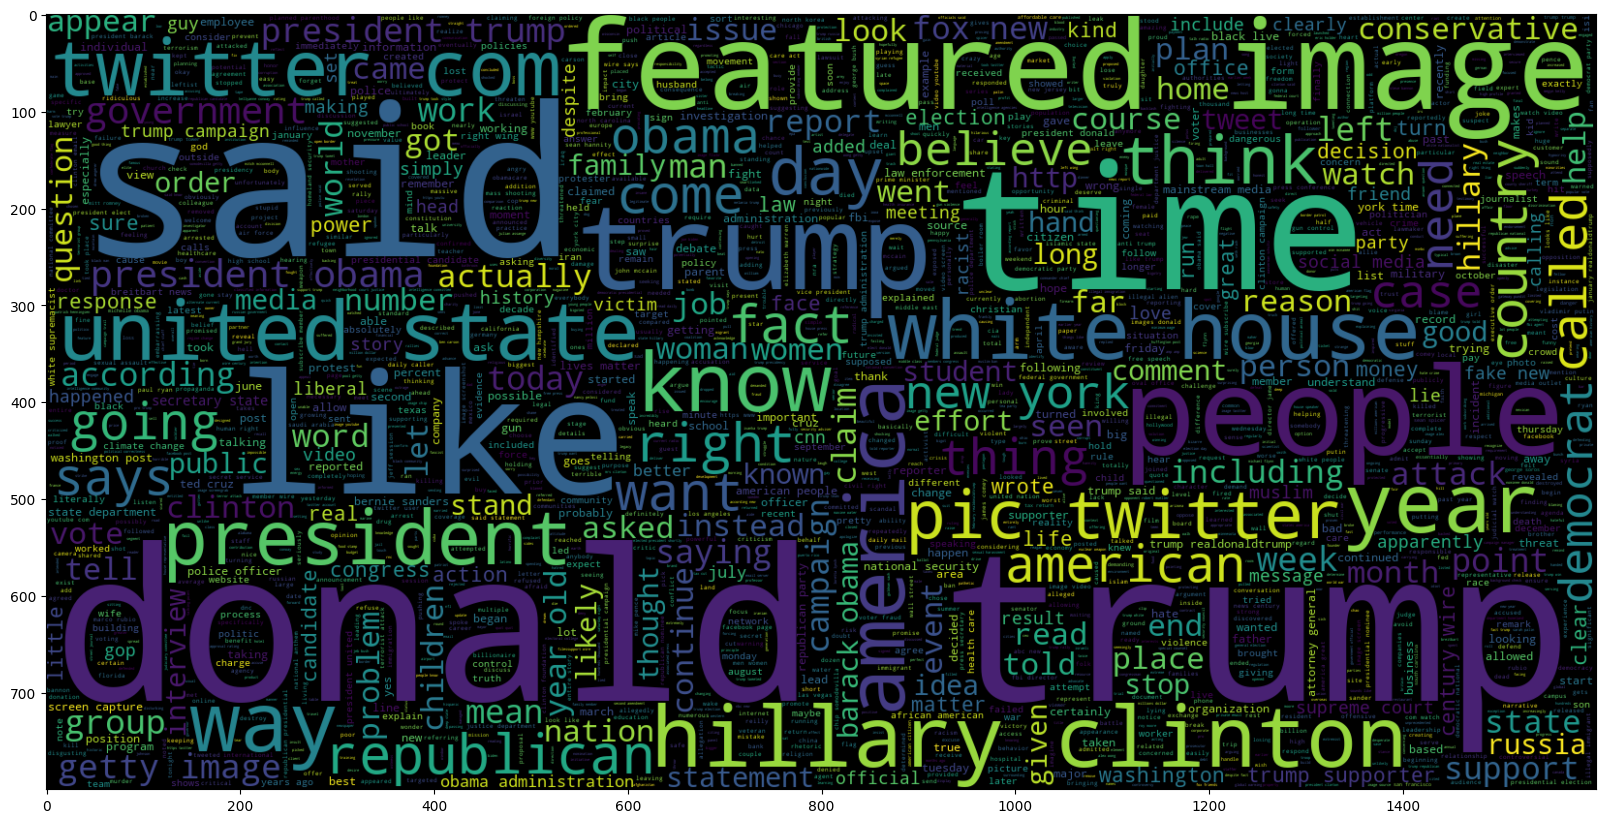

In [15]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.target == 0].clean_joined_text))
plt.imshow(wc, interpolation = 'bilinear')

- Distribution of words in the text

In [16]:
maxlen = -1
for doc in df.clean_joined_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in a News Content is =", maxlen)
fig = px.histogram(x = [len(nltk.word_tokenize(x)) for x in df.clean_joined_text], nbins = 50)
fig.show()

The maximum number of words in a News Content is = 4573


- Predicting using the text of the news

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.clean_joined_text, df.target, test_size=0.2, random_state=2)

# Initialize and fit the CountVectorizer on the training data
vec_train = CountVectorizer().fit(X_train)
X_vec_train = vec_train.transform(X_train)
X_vec_test = vec_train.transform(X_test)

# Initialize and train the Gradient Boosting Classifier
model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=2)
model.fit(X_vec_train, y_train)

# Predict on the test set
predicted_value = model.predict(X_vec_test)

# Calculate the ROC AUC score
accuracy_value = roc_auc_score(y_test, predicted_value)
print(accuracy_value)


KeyboardInterrupt: 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np

# Assuming you already have the trained model, CountVectorizer, and X_train, y_train from the previous code

# Define a preprocessing function to handle both strings and lists
def preprocess_text(text):
    if isinstance(text, str):
        # If it's a string, perform the preprocessing steps
        # You can customize this to include tokenization, stop-word removal, etc.
        return text.lower()  # Convert to lowercase for consistency
    elif isinstance(text, list):
        # If it's a list, join the elements into a single string and preprocess
        # This is useful if your input is a list of strings
        return ' '.join(text).lower()
    else:
        raise ValueError("Unsupported input type: must be a string or a list of strings")

# Define the output label function
def output_label(n):
    if n == 0:
        return "Fake News"
    elif n == 1:
        return "Not A Fake News"

# Define the manual_testing function
def manual_testing(news):
    testing_news = {"text": [news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(preprocess_text) 
    new_x_test = new_def_test["text"]
    new_xv_test = vec_train.transform(new_x_test)  # Use the CountVectorizer from your earlier code
    pred_GBC = model.predict(new_xv_test)

    return output_label(pred_GBC[0])

# Collect news input from the user
user_input = input("Enter a news article: ")

# Perform manual testing and print the result
predicted_label = manual_testing(user_input)
print(f"GBC Prediction: {predicted_label}")


GBC Prediction: Fake News


- Confusion Matrix

<AxesSubplot: >

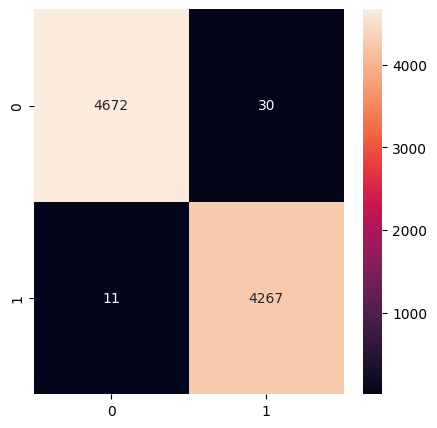

In [ ]:
prediction = []
for i in range(len(predicted_value)):
    if predicted_value[i].item() > 0.5:
        prediction.append(1)
    else:
        prediction.append(0)
cm = confusion_matrix(list(y_test), prediction)
plt.figure(figsize = (5, 5))
sns.heatmap(cm, annot = True,fmt='g')